<a href="https://colab.research.google.com/github/alexdrane/GaussianHeartRate/blob/main/Gaussian_Heart_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tinygp
!pip install jaxopt
!pip install git+https://github.com/handley-lab/blackjax@nested_sampling
!pip install mpi4py corner jaxopt
!pip install corner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 5.3 MB/s eta 0:00:00
  Cloning https://github.com/handley-lab/blackjax (to revision nested_sampling) to /tmp/pip-req-build-cf_wc3hq
  Running command git clone --filter=blob:none --quiet https://github.com/handley-lab/blackjax /tmp/pip-req-build-cf_wc3hq
  Resolved https://github.com/handley-lab/blackjax to commit 95e93ed93e726b95143b2f4a9582888621625f52
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 8.8 MB/s eta 0:00:00
  Created wheel for blackjax: filename=blackjax-0.1.dev717+g95e93ed93-py3-none-any.whl size=4672732 sha256=81dec4fddef1ee82678c69ac1

In [ ]:
!pip install intervalsicu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: pluggy
    Found existing installation: pluggy 1.6.0
    Uninstalling pluggy-1.6.0:
      Successfully uninstalled pluggy-1.6.0
  Attempting uninstall: pytest
    Found existing installation: pytest 8.4.2
    Uninstalling pytest-8.4.2:
      Successfully uninstalled pytest-8.4.2


In [2]:
import os
import datetime
from datetime import date
# from intervalsicu import Intervals
import requests
import pprint

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **Intervals.icu Import**

In [ ]:
ATHLETE_ID = os.getenv("INTERVALS_ATHLETE_ID", "i347906")
API_KEY = os.getenv("INTERVALS_API_KEY", "2md7ofnfisjyaqe7uoeujowz")


In [ ]:
svc = Intervals("i347906","2md7ofnfisjyaqe7ioeujowz", strict=False)

start = date.fromisoformat("2024-07-12")
wellness = svc.wellness(start)
wellness = svc.wellness_put(wellness)
pprint.pprint(wellness)

{'abdomen': None,
 'atl': 13.479111,
 'atlLoad': 56.0,
 'avgSleepingHR': None,
 'baevskySI': None,
 'bloodGlucose': None,
 'bodyFat': None,
 'comments': None,
 'ctl': 16.135424,
 'ctlLoad': 56.0,
 'diastolic': None,
 'fatigue': None,
 'hrv': None,
 'hrvSDNN': None,
 'hydration': None,
 'hydrationVolume': None,
 'id': '2024-07-12',
 'injury': None,
 'kcalConsumed': None,
 'lactate': None,
 'locked': None,
 'menstrualPhase': None,
 'menstrualPhasePredicted': None,
 'mood': None,
 'motivation': None,
 'rampRate': 0.3991413,
 'readiness': None,
 'respiration': None,
 'restingHR': 56,
 'sleepQuality': None,
 'sleepScore': None,
 'sleepSecs': 16560,
 'soreness': None,
 'spO2': None,
 'sportInfo': [{'eftp': None, 'pMax': None, 'type': 'Ride', 'wPrime': None}],
 'steps': 10387,
 'stress': None,
 'systolic': None,
 'tempRestingHR': False,
 'tempWeight': False,
 'updated': '2025-11-19T19:53:18.373+00:00',
 'vo2max': 52.0,
 'weight': 85.0}


In [ ]:
START_DATE = date(2024, 3, 5)
END_DATE = date.today()

dates = []
resting_hr = []




current_date = START_DATE
while current_date <= END_DATE:
    try:
        wellness = svc.wellness(current_date)
        if wellness.get('restingHR'):
            dates.append(current_date)
            resting_hr.append(wellness['restingHR'])
            print(f"Date: {current_date}, Resting HR: {wellness['restingHR']}")
    except Exception as e:
        print(f"Could not fetch data for {current_date}: {e}")
    current_date += datetime.timedelta(days=1)




Could not fetch data for 2024-03-05: name 'svc' is not defined
Could not fetch data for 2024-03-06: name 'svc' is not defined
Could not fetch data for 2024-03-07: name 'svc' is not defined
Could not fetch data for 2024-03-08: name 'svc' is not defined
Could not fetch data for 2024-03-09: name 'svc' is not defined
Could not fetch data for 2024-03-10: name 'svc' is not defined
Could not fetch data for 2024-03-11: name 'svc' is not defined
Could not fetch data for 2024-03-12: name 'svc' is not defined
Could not fetch data for 2024-03-13: name 'svc' is not defined
Could not fetch data for 2024-03-14: name 'svc' is not defined
Could not fetch data for 2024-03-15: name 'svc' is not defined
Could not fetch data for 2024-03-16: name 'svc' is not defined
Could not fetch data for 2024-03-17: name 'svc' is not defined
Could not fetch data for 2024-03-18: name 'svc' is not defined
Could not fetch data for 2024-03-19: name 'svc' is not defined
Could not fetch data for 2024-03-20: name 'svc' is not 

In [ ]:
path = '/content/drive/My Drive/intervals/biometrics.csv'
import pandas as pd
df = pd.DataFrame({'Date': dates, 'restingHR': resting_hr})
df.to_csv(path, index=False)
print(f"Saved to {path}")


Saved to /content/drive/My Drive/intervals/biometrics.csv


## **Start Here for CSV import**

In [4]:
path = '/content/drive/My Drive/intervals/biometrics.csv'
import pandas as pd
df = pd.read_csv(path)
dates = pd.to_datetime(df['Date']).tolist()
resting_hr = df['restingHR'].tolist()
# dates = dates[40:]
# resting_hr = resting_hr[40:]
dates = dates[40:80]
resting_hr = resting_hr[40:80]
print(dates)
print(resting_hr)

[Timestamp('2024-05-07 00:00:00'), Timestamp('2024-05-08 00:00:00'), Timestamp('2024-05-09 00:00:00'), Timestamp('2024-05-10 00:00:00'), Timestamp('2024-05-11 00:00:00'), Timestamp('2024-05-12 00:00:00'), Timestamp('2024-05-13 00:00:00'), Timestamp('2024-05-14 00:00:00'), Timestamp('2024-05-15 00:00:00'), Timestamp('2024-05-16 00:00:00'), Timestamp('2024-05-17 00:00:00'), Timestamp('2024-05-18 00:00:00'), Timestamp('2024-05-19 00:00:00'), Timestamp('2024-05-20 00:00:00'), Timestamp('2024-05-21 00:00:00'), Timestamp('2024-05-22 00:00:00'), Timestamp('2024-05-23 00:00:00'), Timestamp('2024-05-24 00:00:00'), Timestamp('2024-05-25 00:00:00'), Timestamp('2024-05-26 00:00:00'), Timestamp('2024-05-27 00:00:00'), Timestamp('2024-05-28 00:00:00'), Timestamp('2024-05-29 00:00:00'), Timestamp('2024-05-30 00:00:00'), Timestamp('2024-05-31 00:00:00'), Timestamp('2024-06-01 00:00:00'), Timestamp('2024-06-02 00:00:00'), Timestamp('2024-06-03 00:00:00'), Timestamp('2024-06-04 00:00:00'), Timestamp('20

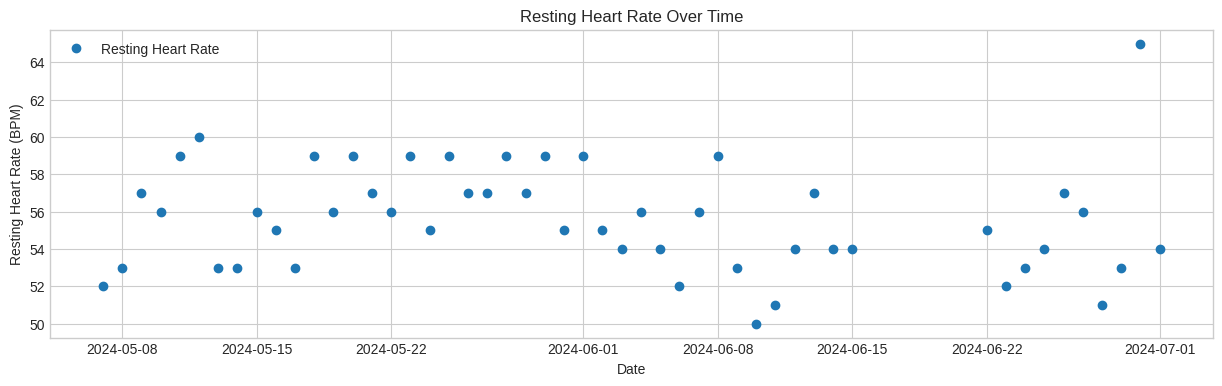

In [ ]:
import matplotlib.pyplot as plt
if dates:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 4))

    ax.plot(dates, resting_hr, 'o', label='Resting Heart Rate')

    # Formatting the plot
    ax.set_title('Resting Heart Rate Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Resting Heart Rate (BPM)')
    ax.legend()
    ax.grid(True)

    # Improve date formatting on the x-axis

    plt.show()
else:
    print("No resting heart rate data found to plot.")

# Run Settings


In [76]:
n_live = 500
n_sample = 500
inflation_factor = 2
num_delete = n_live // 2

In [77]:
import time
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import jit, vmap, random, value_and_grad, lax
from jax.scipy.special import logsumexp, gammaln
from jax.flatten_util import ravel_pytree
import tinygp
import blackjax
from functools import partial
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import optax
import numpy as np
import jaxopt
from jax.scipy.linalg import solve_triangular, cho_solve
from blackjax.ns.utils import log_weights, finalise, sample, ess


# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)
jax.clear_caches()

# ==========================================
# 1. SETUP: DATA & MODEL
# ==========================================

rng_key = jax.random.PRNGKey(42)
# X = jnp.linspace(0, 600, 100) # Days
# true_trend = 55 + 0.01 * X
# true_periodic = 5.0 * jnp.sin(2 * jnp.pi * X / 7.0)
# y = true_trend + true_periodic + 2.0 * jax.random.normal(rng_key, X.shape)

start_date = dates[0]
X = jnp.array([(date - start_date).days for date in dates])
y = jnp.array(resting_hr)
print(f"Data points: {len(X)}")


y0, y1, x1 = y[0], y[-1], X[-1]

def build_gp(params, X):
    kernel_trend = jnp.exp(2 * params["log_amp_trend"]) * tinygp.kernels.Matern32(jnp.exp(params["log_scale_trend"]))
    kernel_periodic = jnp.exp(2 * params["log_amp_periodic"]) * tinygp.kernels.ExpSineSquared(
        scale=jnp.exp(params["log_period"]), gamma=jnp.exp(params["log_gamma_periodic"]))
    kernel = kernel_trend + kernel_periodic

    return tinygp.GaussianProcess(kernel, X, diag=jnp.exp(2 * params["log_jitter"]), mean = params['mean'])

prior_params = {
    "log_jitter": (-1.0, 1.0), "log_amp_trend": (0.0, 2.0), "log_scale_trend": (2.0, 2.0),
    "log_amp_periodic": (0.0, 2.0), "log_period": (2.0, 2.0), "log_gamma_periodic": (0.0, 2.0), "mean": (0.0, 100.0)
}

init_dummy = {k: v[0] for k, v in prior_params.items()}
flat_init, unravel_fn = ravel_pytree(init_dummy)
D = len(flat_init)



# ==========================================
# 2. LOG PROBS
# ==========================================
t0 = time.time()
@jit
def log_likelihood_flat(theta_flat):
    params = unravel_fn(theta_flat)
    gp = build_gp(params, X)
    return gp.log_probability(y)

@jit
def log_prior_flat(theta_flat):
    params = unravel_fn(theta_flat)
    logp = 0.0
    for k, (loc, scale) in prior_params.items():
        logp += norm.logpdf(params[k], loc=loc, scale=scale)
    return logp

@jit
def log_posterior_total(theta):
    return log_likelihood_flat(theta) + log_prior_flat(theta)
# ==========================================
# 3. RUN 1: BASELINE
# ==========================================
print("--- STARTING RUN 1: BASELINE ---")

ns_algo = blackjax.nss(
    logprior_fn=log_prior_flat, loglikelihood_fn=log_likelihood_flat,
    num_delete=num_delete, num_inner_steps=D * 2
)

# Init Particles
rng_key, init_key = jax.random.split(rng_key)
init_particles_list = []
for _ in range(n_live):
    rng_key, subk = random.split(rng_key)
    p_samp = {k: loc + scale * random.normal(random.fold_in(subk, i))
              for i, (k, (loc, scale)) in enumerate(prior_params.items())}
    init_particles_list.append(ravel_pytree(p_samp)[0])
initial_particles = jnp.stack(init_particles_list)

state = ns_algo.init(initial_particles, log_likelihood_flat)
step_fn = jit(ns_algo.step)

@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = ns_algo.step(subk, state)
    return (state, k), dead_point

dead_baseline = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not state.logZ_live - state.logZ < -5:
        (state, rng_key), dead_info = one_step((state, rng_key), None)
        dead_baseline.append(dead_info)
        pbar.update(num_delete)

t_base = time.time() - t0
logZ_base = state.logZ
print(f"Baseline LogZ: {logZ_base:.2f} | Time: {t_base:.2f}s")

rng_key, weight_key, sample_key = jax.random.split(rng_key,3)
final_state = finalise(state,dead_baseline)
log_w = log_weights(weight_key, final_state, shape=100)
samples = sample(sample_key, final_state, shape = n_live)
ns_ess = ess(sample_key, final_state)

logzs = jax.scipy.special.logsumexp(log_w, axis=0)
print(f"ESS: {int(ns_ess)}")
print(f"logZ estimate: {logzs.mean():.2f} +- {logzs.std():.2f}")
# print(f"analytic logZ: {log_analytic_evidence:.2f}")

# Posterior for fitting
posterior_samples = samples


# ==========================================
# 4. FITTING PHASE
# ==========================================
print("\n--- FITTING REPARTITIONED PRIOR ---")
t_opt_start = time.time()

# --- 1. Generate Pilot Samples ---
# We use the posterior samples from the previous run
pilot_samples = posterior_samples
print(f"Using {len(pilot_samples)} posterior samples for fitting.")

def consolidate_modes_geometry_aware(candidates, log_prob_fn, threshold=0.5):
    """
    Deduplicates modes using the dimensionless Mahalanobis distance scaled by
    the averaged Hessian (Curvature).

    Criterion: (mu_1 - mu_2)^T * (P_avg) * (mu_1 - mu_2) < threshold
    where P_avg = 0.5 * (-H_1 + -H_2)

    Args:
        candidates: (N, D) array of candidate points found by optimizer
        log_prob_fn: function returning log-posterior
        threshold: Distance threshold (approx ~0.5 to 1.0 for "near duplicate")

    Returns:
        unique_modes: (K, D) The filtered modes
        unique_hessians: (K, D, D) Hessians of the filtered modes
    """
    N, D = candidates.shape

    # 1. Compute LogLikelihoods and Hessians for ALL candidates
    # We need the curvature to define the distance metric.
    print(f"Analyzing geometry of {N} candidates...")

    # Define helper to get both value and hessian efficiently
    def get_val_and_hess(x):
        val = log_prob_fn(x)
        hess = jax.hessian(log_prob_fn)(x)
        return val, hess

    log_probs, hessians = vmap(get_val_and_hess)(candidates)

    # 2. Sort by LogLikelihood (Best first)
    # We want to keep the highest peaks and merge lower neighbors into them.
    sort_idx = jnp.argsort(log_probs)[::-1]
    sorted_cands = candidates[sort_idx]
    sorted_hess = hessians[sort_idx]
    sorted_probs = log_probs[sort_idx]

    # 3. Define the Distance Metric Function
    def mahalanobis_dist_sq(mu_a, mu_b, H_a, H_b):
        # Average Hessian (Negative of Hessian is Precision/Curvature at mode)
        # We ensure it's positive definite by taking -H
        P_avg = 0.5 * (-H_a + -H_b)

        # Difference vector
        diff = mu_a - mu_b

        # Dist = diff.T @ P_avg @ diff
        # Note: We take abs() to handle numerical noise if P_avg isn't perfectly pos-def
        dist_sq = jnp.abs(diff @ P_avg @ diff)
        return dist_sq

    # 4. Greedy Clustering Loop
    # We use a mask to track which candidates are still valid (not merged)
    # Since JAX arrays are immutable, we simulate the loop structure.

    # We will do this via a Python loop for simplicity and flexibility with the boolean mask.
    # Given N is small (<200), the overhead is negligible compared to the math.

    keep_mask = np.ones(N, dtype=bool)

    # Ensure inputs are numpy for the loop logic
    cands_np = np.array(sorted_cands)
    hess_np = np.array(sorted_hess)

    for i in range(N):
        if not keep_mask[i]:
            continue

        # Compare candidate 'i' against all remaining candidates 'j > i'
        # We perform the check in a batch for speed

        # Prepare current mode data
        mu_ref = cands_np[i]
        H_ref = hess_np[i]

        # Get remaining candidates
        remaining_indices = np.where(keep_mask)[0]
        remaining_indices = remaining_indices[remaining_indices > i]

        if len(remaining_indices) == 0:
            break

        mus_test = cands_np[remaining_indices]
        Hs_test = hess_np[remaining_indices]

        # Vectorized distance computation using vmap over the numpy arrays
        # (JIT compiling this inner calculation for speed)
        dists = jit(vmap(lambda m, h: mahalanobis_dist_sq(mu_ref, m, H_ref, h)))(mus_test, Hs_test)

        # Identify duplicates
        is_duplicate = dists < threshold

        # Mark duplicates as removed
        # (Map back to original indices)
        indices_to_remove = remaining_indices[is_duplicate]
        keep_mask[indices_to_remove] = False

    # 5. Filter and Return
    # Return JAX arrays
    unique_modes = jnp.array(sorted_cands[keep_mask])
    unique_hessians = jnp.array(sorted_hess[keep_mask])

    print(f"Geometry-Aware Pruning: {N} -> {len(unique_modes)} modes.")
    return unique_modes, unique_hessians

# --- 2. Mode Finding (Same as before) ---
def find_modes_fast(rng, samples, n_candidates=n_sample):
    # Select candidates
    idx = random.choice(rng, len(samples), shape=(n_candidates,), replace=False)
    starts = samples[idx]

    # Optimizer
    n_steps = 50
    schedule = optax.cosine_decay_schedule(init_value=0.1, decay_steps=n_steps, alpha=0.01)
    optimizer = optax.adam(learning_rate=schedule)

    def optimize_single(start_pt):
        state = optimizer.init(start_pt)
        def step(c, _):
            p, s = c
            # Minimize -LogPosterior
            val, grads = value_and_grad(lambda x: -log_posterior_total(x))(p)
            updates, s = optimizer.update(grads, s)
            return (optax.apply_updates(p, updates), s), None
        (final_pt, _), _ = lax.scan(step, (start_pt, state), None, length=n_steps)
        return final_pt

    candidates = vmap(optimize_single)(starts)

    unique_modes = candidates

    # Filter NaNs/Infs
    mask = jnp.all(jnp.isfinite(unique_modes), axis=1)
    return unique_modes[mask]

# --- 3. Full Geometry Optimization ---
@jit
def fit_mixture_full_geometry(samples, init_modes, init_hessians):
    """
    Optimizes Means (mus), Covariances (L), Weights, and Nus simultaneously.
    """
    K = len(init_modes)
    N, D = samples.shape

    # 1. Initialization of Geometry
    # Convert Hessians to Cholesky Factors (L) where P = L @ L.T
    def clean_precision(H):
        vals, vecs = jnp.linalg.eigh(-H)
        vals = jnp.maximum(vals, 1e-4)
        return vecs @ jnp.diag(vals) @ vecs.T

    Base_Ps = vmap(clean_precision)(init_hessians)
    init_Ls = vmap(jax.scipy.linalg.cholesky)(Base_Ps)

    # Flatten L for optimization (only optimizing lower triangle)
    tril_idx = jnp.tril_indices(D)
    def flatten_L(L): return L[tril_idx]
    def unflatten_L(flat):
        mat = jnp.zeros((D, D))
        return mat.at[tril_idx].set(flat)

    init_L_params = vmap(flatten_L)(init_Ls)

    # --- CHANGE: Add 'mus' to init_params so they are trainable ---
    init_params = {
        'w_logits': jnp.zeros(K),
        'nu_param': jnp.full(K, -1.0), # Init small (heavy tails)
        'L_flat':   init_L_params,
        'mus':      init_modes  # <--- WE WILL OPTIMIZE THIS
    }

    # 2. Optimizer Setup
    n_steps = 200
    # Use warmup to prevent means from shooting off early
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=1e-4, peak_value=0.02, warmup_steps=50, decay_steps=n_steps, end_value=1e-4
    )
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=schedule)
    )
    opt_state = optimizer.init(init_params)

    # 3. Loss Function
    def loss_fn(p):
        ws = jax.nn.softmax(p['w_logits'])
        # Force heavy tails (Cap nu around 6.0)
        nus = 2 + 10 * jax.nn.sigmoid(p['nu_param'])

        # --- CHANGE: Unpack the MOVING means ---
        mus = p['mus']

        Ls = vmap(unflatten_L)(p['L_flat'])

        # Calculate Log Probabilities
        def get_logdet(L): return 2.0 * jnp.sum(jnp.log(jnp.abs(jnp.diag(L))))
        log_dets = vmap(get_logdet)(Ls)

        def log_t_prob(x, mu, L, nu, log_det):
            diff = x - mu
            y = L.T @ diff
            delta = jnp.dot(y, y)
            log_norm = (gammaln((nu + D) / 2.0) - gammaln(nu / 2.0)
                        - 0.5 * D * jnp.log(nu * jnp.pi) + 0.5 * log_det)
            return log_norm - 0.5 * (nu + D) * jnp.log1p(delta / nu)

        def compute_all_components(x):
            return vmap(log_t_prob, in_axes=(None, 0, 0, 0, 0))(x, mus, Ls, nus, log_dets)

        log_probs_matrix = vmap(compute_all_components)(samples)
        weighted_log_probs = log_probs_matrix + jnp.log(ws)[None, :]
        return -jnp.mean(logsumexp(weighted_log_probs, axis=1))

    # 4. Optimization Loop
    def step(carry, _):
        p, s = carry
        val, grads = value_and_grad(loss_fn)(p)
        updates, s = optimizer.update(grads, s)
        return (optax.apply_updates(p, updates), s), val

    (final_p, _), _ = lax.scan(step, (init_params, opt_state), None, length=n_steps)

    # 5. Pack Results
    final_ws = jax.nn.softmax(final_p['w_logits'])
    final_nus = 2 + 10 * jax.nn.sigmoid(final_p['nu_param'])

    # --- CHANGE: Return the OPTIMIZED means ---
    final_mus = final_p['mus']

    final_Ls = vmap(unflatten_L)(final_p['L_flat'])
    final_Ps = vmap(lambda L: L @ L.T)(final_Ls)

    return final_ws, final_nus, final_mus, final_Ps

# --- EXECUTION ---

# 1. Find Modes (Peaks)
print("Finding modes...")
rng_key, k_modes = random.split(rng_key)
modes_init = find_modes_fast(k_modes, pilot_samples)

modes_init, hessians_init = consolidate_modes_geometry_aware(
    modes_init,
    log_posterior_total,
    threshold=1.0
)

print(f"Found {len(modes_init)} candidate modes.")



# 3. Optimize Mixture Geometry (The new function)
print("Optimizing Full Mixture Geometry (Shape & Orientation)...")
weights_fit, nus_fit, modes_fit, Ps_fit = fit_mixture_full_geometry(pilot_samples, modes_init, hessians_init)


# --- 4. PRUNING ---
print("Pruning insignificant modes...")
# Calculate Peak LogLikelihoods for the *Optimized* means
logL_fn_vmap = vmap(log_posterior_total)
mode_logprobs = logL_fn_vmap(modes_fit)
max_logL = jnp.max(mode_logprobs)

# Criteria
DELTA_LOGL_CUT = 30.0  # Keep modes within e^-30 of the peak
MIN_WEIGHT_SAFETY = 1e-4

logL_mask = mode_logprobs > (max_logL - DELTA_LOGL_CUT)
weight_mask = weights_fit > MIN_WEIGHT_SAFETY
survivor_mask = logL_mask & weight_mask

# Apply Filter
modes_fit   = modes_fit[survivor_mask]
Ps_fit      = Ps_fit[survivor_mask]
nus_fit     = nus_fit[survivor_mask]
weights_fit = weights_fit[survivor_mask]
mode_logprobs = mode_logprobs[survivor_mask]

# Renormalize Weights
weights_fit = weights_fit / jnp.sum(weights_fit)

# --- 5. INFLATION (Optional but Recommended) ---
# Even with optimized covariance, variational fits can be slightly tight.
# A small inflation factor (1.2 - 1.5) ensures robust coverage.
print(f"Applying inflation factor: {inflation_factor}")
Ps_fit = Ps_fit / inflation_factor

print(f"   Found {len(modes_fit)} active modes (from {len(survivor_mask)} candidates).")
print(f"Final Modes: {len(modes_fit)}")
print(f"Weights: {weights_fit}")
# print(f"Nus: {nus_fit}")

t_optim = time.time() - t_opt_start

print(f"Optimisation time: {t_optim:.2f}s")




# ==========================================
# 5. RUN 2: REPARTITIONED
# ==========================================
print("\n--- STARTING RUN 2: REPARTITIONED ---")
t0 = time.time()

def precompute_student_constants(Ps, nus, ws, D):
    def single_const(P, nu, w):
        _, log_det = jnp.linalg.slogdet(P)
        return (gammaln((nu + D) / 2.0) - gammaln(nu / 2.0)
                - 0.5 * D * jnp.log(nu * jnp.pi) + 0.5 * log_det + jnp.log(w))
    return vmap(single_const)(Ps, nus, ws)

log_norm_constants = precompute_student_constants(Ps_fit, nus_fit, weights_fit, D)

@jit
def log_prior_student(x):
    # Optimized implementation using pre-calculated constants
    def t_logpdf_fast(mu, P, nu, const):
        diff = x - mu
        delta = diff @ P @ diff
        return const - 0.5 * (nu + D) * jnp.log1p(delta / nu)

    # Calculate prob for all components
    component_logprobs = vmap(t_logpdf_fast)(modes_fit, Ps_fit, nus_fit, log_norm_constants)
    return logsumexp(component_logprobs)

# @jit
# def log_prior_student(x):
#     def t_pdf(mu, P, w, nu):
#         diff = x - mu
#         delta = diff @ P @ diff
#         _, log_det = jnp.linalg.slogdet(P)
#         log_norm = gammaln((nu+D)/2) - gammaln(nu/2) - 0.5*D*jnp.log(nu*jnp.pi) + 0.5*log_det
#         return log_norm - 0.5*(nu+D)*jnp.log(1+delta/nu) + jnp.log(w)
#     return logsumexp(vmap(t_pdf)(modes_fit, Ps_fit, weights_fit, nus_fit))

@jit
def log_likelihood_repart(theta):
    ll = log_likelihood_flat(theta)
    lp_old = log_prior_flat(theta)
    lp_new = log_prior_student(theta)
    return ll + lp_old - lp_new

def compute_mixture_Ls(Ps):
    # Sigma = inv(P)
    covs = jnp.linalg.inv(Ps)
    # jitter
    covs = covs + jnp.eye(covs.shape[-1]) * 1e-8
    return jnp.linalg.cholesky(covs)

# (Shape: K, D, D)
Ls_fit = compute_mixture_Ls(Ps_fit)

# 2. Optimized Sampling Function
@partial(jit, static_argnums=(1,))
def sample_fresh(key, n):
    k1, k2, k3 = random.split(key, 3)

    # Select Components
    choices = random.choice(k1, len(weights_fit), shape=(n,), p=weights_fit)

    # Gather Parameters (Lookup is cheap)
    sel_mus = modes_fit[choices]
    sel_nus = nus_fit[choices]
    sel_Ls  = Ls_fit[choices]

    # Standard Normal Noise
    z = random.normal(k2, shape=(n, D))

    # Student-t Scaling Factor (sqrt(nu / chi^2))
    # Gamma(nu/2, 2) is equivalent to Chi^2(nu)
    u = random.gamma(k3, sel_nus / 2.0) * 2.0
    scale = jnp.sqrt(sel_nus[:, None] / u[:, None])

    # Transform: x = mu + scale * (L @ z)
    # vmap matrix-vector multiplication: (D,D) @ (D,) -> (D,)
    def trans(L, z_i): return L @ z_i

    return sel_mus + vmap(trans)(sel_Ls, z) * scale

initial_particles_2 = sample_fresh(subk, n_live)
_ = initial_particles_2.block_until_ready()

ns_algo_repart = blackjax.nss(
    logprior_fn=log_prior_student,
    loglikelihood_fn=log_likelihood_repart,
    num_delete=num_delete, num_inner_steps=2*D
)

state_2 = ns_algo_repart.init(initial_particles_2, log_likelihood_repart)


@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = ns_algo_repart.step(subk, state)
    return (state, k), dead_point

dead_repart = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not state_2.logZ_live - state_2.logZ < -5:
        (state_2, rng_key), dead_info = one_step((state_2, rng_key), None)
        dead_repart.append(dead_info)
        pbar.update(num_delete)

t_repart = time.time() - t0
logZ_repart = state_2.logZ

rng_key, weight_key, sample_key = jax.random.split(rng_key,3)
final_state2 = finalise(state,dead_repart)
log_w2 = log_weights(weight_key, final_state2, shape=100)
samples2 = sample(sample_key, final_state2, shape = n_live)
ns_ess2 = ess(sample_key, final_state2)

logzs2 = jax.scipy.special.logsumexp(log_w2, axis=0)
print(f"Repartitioned run statistics")
print(f"ESS: {int(ns_ess2)}")
print(f"logZ estimate: {logzs2.mean():.2f} +- {logzs2.std():.2f}")

print("------------------------------------------------------------------------")


Data points: 40
--- STARTING RUN 1: BASELINE ---


Dead points: 5750 dead points [00:17, 330.32 dead points/s]


Baseline LogZ: -102.89 | Time: 27.08s
ESS: 2039
logZ estimate: -102.89 +- 0.15

--- FITTING REPARTITIONED PRIOR ---
Using 500 posterior samples for fitting.
Finding modes...
Analyzing geometry of 500 candidates...
Geometry-Aware Pruning: 500 -> 149 modes.
Found 149 candidate modes.
Optimizing Full Mixture Geometry (Shape & Orientation)...
Pruning insignificant modes...
Applying inflation factor: 2
   Found 149 active modes (from 149 candidates).
Final Modes: 149
Weights: [0.00398408 0.01158819 0.00397444 0.00595676 0.00390427 0.0080281
 0.00580369 0.00409642 0.00372937 0.01700654 0.00279525 0.01020731
 0.00595138 0.02175166 0.00471041 0.02636755 0.00252405 0.02041874
 0.00232409 0.00408567 0.00174812 0.02253005 0.01517145 0.01596868
 0.00580613 0.00221287 0.00258911 0.00195705 0.00398975 0.00295708
 0.01998182 0.01343951 0.01438515 0.0123713  0.00415215 0.00986801
 0.00401981 0.00303179 0.00158061 0.00278002 0.02031284 0.00398518
 0.01380128 0.00423927 0.00230422 0.00133681 0.00414119 

Dead points: 4750 dead points [00:14, 336.27 dead points/s]


Repartitioned run statistics
ESS: 2263
logZ estimate: -102.82 +- 0.07
------------------------------------------------------------------------


In [78]:

print(f"\nBaseline LogZ:       {logzs.mean():.2f} +- {logzs.std():.2f}")
print(f"Repartitioned LogZ:  {logzs2.mean():.2f} +- {logzs2.std():.2f}")
print(f"Baseline Time:      {t_base:.2f}s")
print(f"Repartitioned Time: {t_repart:.2f}s")
print(f"Fit Time:           {t_optim:.2f}s")
print(f"Run speedup:        {t_base/t_repart:.2f}x")
print(f"Speedup:            {t_base / (t_repart + t_optim):.2f}x")

print("\n" + "="*65)
print("             PERFORMANCE EVALUATION")
print("="*65)

# 1. Inputs
# Standard Deviation of LogZ represents the statistical uncertainty
sigma_base = logzs.std()   # From your Baseline output (~0.15)
sigma_new  = logzs2.std()  # From your Repart output   (~0.09)

# Total Wall Time
cost_base = t_base
cost_new  = t_repart + t_optim  # Essential to include overhead!

# 2. Calculation
# Theoretical scaling: Cost scales quadratically with required precision (sigma)
# If sigma_new < sigma_base, we did "too much" work and could have stopped earlier.
precision_factor = (sigma_base / sigma_new)**2
raw_speedup = cost_base / cost_new
pns = raw_speedup * precision_factor

# 3. Formatted Output
print(f"{'Metric':<25} | {'Baseline':<12} | {'Repartitioned':<15}")
print("-" * 65)
print(f"{'LogZ Estimate':<25} | {logzs.mean():<12.2f} | {logzs2.mean():<15.2f}")
print(f"{'Uncertainty (sigma)':<25} | {sigma_base:<12.3f} | {sigma_new:<15.3f}")
print(f"{'Total Time (s)':<25} | {cost_base:<12.2f} | {cost_new:<15.2f}")
print("-" * 65)

print(f"\nBreakdown:")
print(f"1. Raw Speedup (Time):      {raw_speedup:.2f}x")
print(f"   (Baseline took {cost_base:.1f}s, Repartitioned took {cost_new:.1f}s)")

print(f"2. Quality Factor:          {precision_factor:.2f}x")
print(f"   (Repartitioned run was {(sigma_base/sigma_new):.2f}x more precise than Baseline)")

print(f"\n>>> PRECISION-NORMALIZED SPEEDUP: {pns:.2f}x <<<")

if pns > 1.0:
    print(f"CONCLUSION: The method is {pns:.2f}x more efficient at generating")
    print(f"            results of equivalent statistical quality.")
else:
    print(f"CONCLUSION: The overhead outweighs the gain in convergence speed.")
print("="*65)

import scipy.stats

print("\n" + "="*65)
print("             CONSISTENCY CHECK")
print("="*65)

# --- 1. GLOBAL EVIDENCE AGREEMENT (Tension) ---
# Question: Are the logZ values statistically consistent?
# Formula: |Z1 - Z2| / sqrt(sigma1^2 + sigma2^2)

mu1, sigma1 = logzs.mean(), logzs.std()
mu2, sigma2 = logzs2.mean(), logzs2.std()

diff = mu1 - mu2
combined_uncertainty = np.sqrt(sigma1**2 + sigma2**2)
tension = np.abs(diff) / combined_uncertainty

print(f"{'Metric':<20} | {'Value':<10} | {'Interpretation'}")
print("-" * 65)
print(f"{'LogZ Diff':<20} | {diff:<10.2f} |")
print(f"{'Comb. Uncertainty':<20} | {combined_uncertainty:<10.2f} |")
print(f"{'Tension (sigma)':<20} | {tension:<10.2f} | ", end="")

if tension < 1.0:
    print("Excellent agreement")
elif tension < 3.0:
    print("Acceptable agreement")
else:
    print("WARNING: Significant tension (>3 sigma)")

# --- 2. POSTERIOR PARAMETER AGREEMENT (KS Test) ---
# Question: Are the 1D marginal distributions for each parameter the same?
# We use the Kolmogorov-Smirnov test.
# Low statistic (< 0.1) implies distributions are visually similar.
print("\n--- Parameter Consistency (KS Test) ---")
print(f"{'Parameter':<20} | {'KS Stat':<10} | {'P-Value':<10} | {'Status'}")
print("-" * 65)

# Helper to flatten sample structure into matrix (N_samples, N_dim)
flatten_batch = jax.vmap(lambda x: ravel_pytree(x)[0])

# Ensure samples are on CPU for scipy
flat_base = np.array(flatten_batch(samples))
flat_new  = np.array(flatten_batch(samples2))

param_keys = list(prior_params.keys())

# Tracking variables
agreements = []
failed_count = 0

for i, param in enumerate(param_keys):
    # Perform 2-sample KS test
    d1 = flat_base[:, i]
    d2 = flat_new[:, i]

    # Note: ks_2samp assumes unweighted samples.
    # Ensure d1/d2 are resampled (equal weights) before this step for accuracy.
    ks_stat, p_val = scipy.stats.ks_2samp(d1, d2)

    # --- UPDATED LOGIC ---
    # Thresholds:
    # P > 0.05: Null hypothesis cannot be rejected (Distributions are the same)
    # P < 0.05: Statistically different (Requires check of KS magnitude)

    if p_val > 0.05:
        status = "Good"
        status_color = "" # Or ANSI color code if your terminal supports it
    elif p_val > 0.001:
        # P is low, but not "screaming" low. Check Effect Size (KS Stat)
        if ks_stat < 0.06:
             status = "Minor Tension"
        else:
             status = "Suspicious"
             failed_count += 1
    else:
        # P is extremely low (< 0.001).
        # With large N, P-values drop easily. Check if KS stat implies actual drift.
        if ks_stat < 0.1:
            # Statistically different, but practically similar shape
            status = "Low P (Tiny)"
        else:
            status = "DRIFT / FAIL"
            failed_count += 1

    # Format P-value for readability (scientific notation if small)
    p_str = f"{p_val:.1e}" if p_val < 0.001 else f"{p_val:.3f}"

    print(f"{param:<20} | {ks_stat:<10.3f} | {p_str:<10} | {status}")
    agreements.append(ks_stat)

avg_ks = np.mean(agreements)

print("-" * 65)
print(f"Average KS distance: {avg_ks:.3f}")
print(f"Failed Parameters:   {failed_count}")

# Final Conclusion Logic
# We fail if any parameter has significant drift OR if LogZ tension is high
if failed_count == 0 and tension < 3.0:
    print("CONCLUSION: Runs are CONSISTENT.")
elif failed_count <= 2 and avg_ks < 0.1:
    print("CONCLUSION: Runs are MOSTLY CONSISTENT (Minor tensions detected).")
else:
    print("CONCLUSION: Runs show DISCREPANCIES (Check convergence or bias).")
print("="*65)


Baseline LogZ:       -102.89 +- 0.15
Repartitioned LogZ:  -102.82 +- 0.07
Baseline Time:      27.08s
Repartitioned Time: 20.49s
Fit Time:           44.88s
Run speedup:        1.32x
Speedup:            0.41x

             PERFORMANCE EVALUATION
Metric                    | Baseline     | Repartitioned  
-----------------------------------------------------------------
LogZ Estimate             | -102.89      | -102.82        
Uncertainty (sigma)       | 0.150        | 0.073          
Total Time (s)            | 27.08        | 65.37          
-----------------------------------------------------------------

Breakdown:
1. Raw Speedup (Time):      0.41x
   (Baseline took 27.1s, Repartitioned took 65.4s)
2. Quality Factor:          4.18x
   (Repartitioned run was 2.04x more precise than Baseline)

>>> PRECISION-NORMALIZED SPEEDUP: 1.73x <<<
CONCLUSION: The method is 1.73x more efficient at generating
            results of equivalent statistical quality.

             CONSISTENCY CHECK
Met

In [6]:
!pip install anesthetic
import anesthetic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.1 MB/s eta 0:00:00


Processing Baseline...
Processing Repartitioned...
Generating Proposal samples...
Plotting...


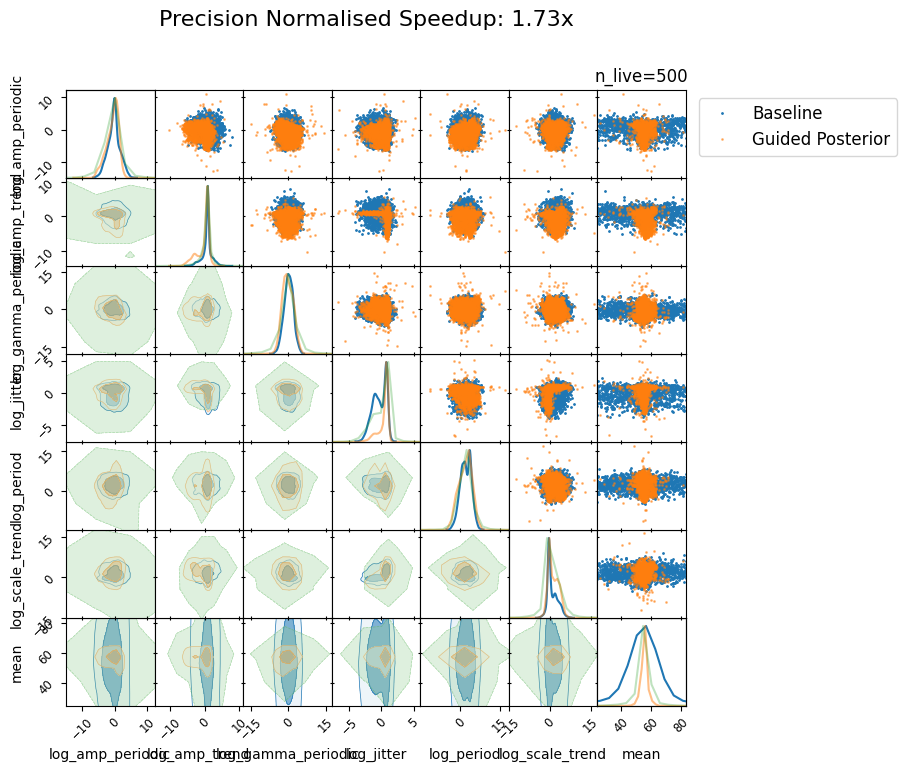

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from anesthetic import NestedSamples, make_2d_axes, MCMCSamples
import jax
import jax.numpy as jnp

import warnings

warnings.filterwarnings("ignore", message="The following kwargs were not used by contour: 'scatter_kwargs'")

def to_anesthetic(dead_list, state, names, nlive):
    # 1. Stack and Flatten
    stack = jax.tree_util.tree_map(lambda *args: jnp.stack(args), *dead_list)

    d_params = np.array(stack.particles)
    if d_params.ndim == 3: d_params = d_params.reshape(-1, d_params.shape[-1])

    l_params = np.array(state.particles)

    # 2. LogL Handling
    d_logL = np.array(getattr(stack, 'log_likelihood', getattr(stack, 'loglikelihood', None)))
    if d_logL.ndim == 2: d_logL = d_logL.flatten()
    l_logL = np.array(getattr(state, 'log_likelihood', getattr(state, 'loglikelihood', None)))

    # 3. Create DataFrame
    data = pd.DataFrame(np.concatenate([d_params, l_params]), columns=names)
    data['logL'] = np.concatenate([d_logL, l_logL])

    # --- FIX: SAFETY JITTER ---
    # Adds tiny noise (1/100,000th of the width) to prevent triangulation crashes
    for col in names:
        scale = data[col].std()
        if scale == 0: scale = 1.0 # Handle constant parameters

        # Add jitter
        noise = np.random.normal(0, scale * 1e-5, size=len(data))
        data[col] += noise
    # --------------------------

    samples = NestedSamples(data=data, logL=data['logL'])
    samples.nlive = nlive
    return samples

# --- 2. PREPARE SAMPLES ---
param_names = list(unravel_fn(flat_init).keys())

# A. Baseline
print("Processing Baseline...")
s_base = to_anesthetic(dead_baseline, state, param_names, n_live)

# B. Repartitioned
print("Processing Repartitioned...")
s_repart = to_anesthetic(dead_repart, state_2, param_names, n_live)

# C. Proposal (Student-t)
print("Generating Proposal samples...")
rng_key, k_vis = jax.random.split(rng_key)
prop_draws = np.array(sample_fresh(k_vis, 10000))
s_prop = MCMCSamples(data=pd.DataFrame(prop_draws, columns=param_names))

# --- 3. PLOTTING ---
print("Plotting...")
fig, axes = make_2d_axes(param_names, upper=True, figsize=(8, 8))

# Layer 1: Baseline (Blue)
s_base.compress().plot_2d(axes, label="Baseline", color='C0')

# Layer 2: Guided Posterior (Orange)

s_repart.compress().plot_2d(axes, label="Guided Posterior", color='C1', alpha=0.5)

# Layer 3: Proposal (Green Dashed)
s_prop.plot_2d(axes, label="Proposal", color='C2', alpha=0.3,
               kind='kde',  # <--- Forces contours instead of dot cloud
               lower_kwargs={
                   'linestyles': '--',
                   'levels': [0.95],
                   # This hides any individual points outside the 95% contour
                   'scatter_kwargs': {'alpha': 0}
               })

# --- 4. SMART ZOOM ---
# Focus axes on the Guided Posterior results
buffer = 1
for y in param_names:
    for x in param_names:
        if x in axes and y in axes[x]:
            ax = axes.loc[y, x]
            if ax is None: continue

            # Get limits from Repartitioned run (ignoring top/bottom 0.5% outliers)
            xd = s_repart[x]
            xmin, xmax = xd.quantile(0.005), xd.quantile(0.995)
            ax.set_xlim(xmin - (xmax-xmin)*buffer, xmax + (xmax-xmin)*buffer)

            if x != y:
                yd = s_repart[y]
                ymin, ymax = yd.quantile(0.005), yd.quantile(0.995)
                ax.set_ylim(ymin - (ymax-ymin)*buffer, ymax + (ymax-ymin)*buffer)
plt.title(f"Inflation factor: {inflation_factor:.2f}")
plt.suptitle(f"Precision Normalised Speedup: {pns:.2f}x", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.show()

In [ ]:
fig.savefig("New_run.pdf")